In [1]:
### Importing Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from Bio import AlignIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
from MLP import ProtDataModule, SeqFcnDataset, MLP
import torch
from matplotlib.colors import Normalize, LinearSegmentedColormap


In [2]:
# Load Data from MSA for ConvVAE format
def get_msa_from_fasta(filename):
    import Bio.SeqIO
    with open(filename, "rt") as fh: 
        return [r[1] for r in Bio.SeqIO.FastaIO.SimpleFastaParser(fh)]

# Quantify sequence similarity
def hamming_dist(s1, s2):
    """Calculates the Hamming distance between two sequences"""
    return sum(1 for x, y in zip(s1, s2) if x != y and x != '-' and y != '-')

# Load sequences from various sources
def load_sequences(file_path, column_name):
    df = pd.read_csv(file_path)
    return df[column_name].tolist()

# Sample dataframes if they exceed the length of df_DMS
def sample_dataframe(df, num_seqs, random_state=9):
    if len(df) > num_seqs:
        return df.sample(n=num_seqs, random_state=random_state)
    return df


In [3]:
# Add CreiLOV sequence to dataframe
WT = "MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"
df_wt = pd.DataFrame({"sequence": [WT], "source": "WT"})
df_wt.head()

,sequence,source
0,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,WT


In [4]:
# Load 513 best mutants from DMS dataset
df_DMS = pd.read_pickle("/Users/nathanielblalock/Desktop/Running_Optuna_SFT_ESM2/SFT_dataset_df_all_mutation_counts.pkl")
df_DMS.rename(columns={"Sequence": "sequence"}, inplace=True)
df_DMS.rename(columns={"log_mean": "score"}, inplace=True)
df_DMS = df_DMS[df_DMS['sequence'] != WT]
df_DMS["source"] = "DMS"
df_DMS.head()


,Masked_Sequence,sequence,Mutations,MutationCount,score,Mutation_Positions,source
1,MAGLRHTFV<mask>ADATLPDCPLVYASEGFYAMTGYGPDEVLGH...,MAGLRHTFVLADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,V10L,1,4.321592,10,DMS
2,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,S100K,1,4.309110,100,DMS
3,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,K101A,1,4.359807,101,DMS
4,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,F102I,1,4.340047,102,DMS
5,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,V103T,1,4.283865,103,DMS


In [5]:
# Load training data for reward models
df = pd.read_pickle("/Users/nathanielblalock/Desktop/RLXF_Projects/data/for_reward_model/CreiLOV_4cluster_df.pkl") # load preprocessed CreiLOV data
dm = ProtDataModule(df,32,'/Users/nathanielblalock/Desktop/RLXF_Projects/data/for_reward_model/CreiLOV_EnsMLP_splits_df.pkl')
train_df, val_df, test_df = dm.get_split_dataframes()
train_df = train_df.copy().reset_index(inplace=False, drop=True)
train_df.rename(columns={"Sequence": "sequence"}, inplace=True)
train_df["source"] = "training_data"
print(len(train_df))
train_df.head()


6925


,ID,rep1,rep2,rep3,mean,log_rep1,log_rep2,log_rep3,log_mean,Mutations,sequence,Cluster,source
0,p.Asn75Thr,2644.780000,2695.802289,1879.107770,2406.560000,3.422389,3.430688,3.273952,3.381397,N75T,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,training_data
1,"p.Thr7Ser, p.Gln47Ile, p.Arg60Asn, p.Val109Gln",9349.673036,5809.796954,7241.303466,7466.924485,3.970796,3.764161,3.859817,3.873142,"T7S,Q47I,R60N,V109Q",MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,training_data
2,p.Gly97Ile,7571.030000,7364.662158,8311.638347,7749.110000,3.879155,3.867153,3.919687,3.889252,G97I,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,training_data
3,"p.Arg60Asn, p.Asp96Gln",9678.442071,9022.562182,8186.967254,8962.657169,3.985805,3.955330,3.913123,3.952437,"R60N,D96Q",MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,training_data
4,"p.Thr7Ser, p.Ala29Lys, p.Ile92Cys, p.Val107Met",12229.159420,13430.345220,12667.048770,12775.517800,4.087397,4.128087,4.102675,4.106379,"T7S,A29K,I92C,V107M",MAGLRHSFVVADATLPDCPLVYASEGFYKMTGYGPDEVLGHNARFL...,1,training_data


In [6]:
# Load sequences from pre-trained, sft, and aligned ESM2
version = 12
dir_filepath = f'../RLXF_PPO_from_pretrained_ESM2_GPU/logs/Aligning_SFT_ESM2s_wpPPO/version_{version}'

df_esm2_fixed = pd.read_csv(f"{dir_filepath}/esm2_t33_650M_UR50D_fixed_mutated_designs_scores.csv")
df_esm2_sft = pd.read_csv(f"{dir_filepath}/esm2_t33_650M_UR50D_sft_mutated_designs_scores.csv")
df_esm2_rl = pd.read_csv(f"{dir_filepath}/ema_aligned_esm2_t33_650M_UR50D_mutated_designs_scores_ep1.csv")
df_esm2_fixed.rename(columns={"Sequence": "sequence", "Score": "score"}, inplace=True)
df_esm2_sft.rename(columns={"Sequence": "sequence", "Score": "score"}, inplace=True)
df_esm2_rl.rename(columns={"Sequence": "sequence", "Score": "score"}, inplace=True)
df_esm2_fixed["source"] = "ESM2_fixed"
df_esm2_sft["source"] = "ESM2_sft"
df_esm2_rl["source"] = "ESM2_rl"
df_esm2_rl.head()

,sequence,score,Mutations,Number of Mutations,source
0,MAGLDHSFVVADATLPDCPLVYASETFYAMTGYGPDEVLGHNARFL...,4.181512,"R5D, T7S, G26T, F102A, K112I",5,ESM2_rl
1,MAGLDHSFVVADATLPDCPLVYASETFYAMTGYGPDEVLGHNARFL...,4.204505,"R5D, T7S, G26T, K54A, K112I",5,ESM2_rl
2,MAGLDHSFVVADATLPDCPLVYASETFYAMTGYGPDEVLGMNARFL...,4.214182,"R5D, T7S, G26T, H41M, K112I",5,ESM2_rl
3,MAGLDHSFVVADATLPDCPLVYASETFYAMTGYGPDEVLGHNARFL...,4.193960,"R5D, T7S, G26T, T88K, K112I",5,ESM2_rl
4,MAGLDHSFVVADATLPDCPLVYASETFYAMTGYGPDEVLGHNARFL...,4.206392,"R5D, T7S, G26T, A68P, K112I",5,ESM2_rl


In [7]:
# Load sequences from pre-trained and aligned VAE
version = 507
dir_filepath = f'../RLXF_Projects/designs/vae_designs/version_{version}'

df_vae_fixed = pd.read_csv(f"{dir_filepath}/fixed_vae_designs_scores_507.csv")
df_vae_rl = pd.read_csv(f"{dir_filepath}/rl_vae_designs_scores_507.csv")
df_vae_fixed.rename(columns={"Sequence": "sequence", "Score": "score"}, inplace=True)
df_vae_rl.rename(columns={"Sequence": "sequence", "Score": "score"}, inplace=True)
df_vae_fixed["source"] = "VAE_fixed"
df_vae_rl["source"] = "VAE_rl"
df_vae_rl.head()

,sequence,score,source
0,MAGLEHTFVVADATLPDCPLVYASEGFYAMTGYQPDEVLGHNARFL...,4.100786,VAE_rl
1,MAGLEHTFVVADATLPDCPLVYASEGFYAMTGYQPDEVLGHNARFL...,4.104236,VAE_rl
2,MAGLEHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.113004,VAE_rl
3,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNANFL...,4.051329,VAE_rl
4,MAGLEHTFVVADATLPDCPLVYASEGFYMMTGYPPDEVLGHNARFL...,4.093050,VAE_rl


In [8]:
# Filter down to number of sequences easier to plot
num_seqs = 500
# df_esm2_fixed = sample_dataframe(df_esm2_fixed, num_seqs)
# df_esm2_sft = sample_dataframe(df_esm2_sft, num_seqs)
# df_esm2_rl = sample_dataframe(df_esm2_rl, num_seqs)
# df_vae_fixed = sample_dataframe(df_vae_fixed, num_seqs)
# df_vae_rl = sample_dataframe(df_vae_rl, num_seqs)


In [9]:
# Load top 5 sequences from aligned ESM2 and VAE
df_vae_best = df_vae_rl.nlargest(5, 'score')[["sequence", "score"]]
df_esm2_best = df_esm2_rl.nlargest(5, 'score')[["sequence", "score"]]


In [10]:
# Combine all dataframes into a single dataframe
df_combined = pd.concat([df_wt, train_df, df_esm2_fixed, df_esm2_sft, df_esm2_rl, df_vae_fixed, df_vae_rl], ignore_index=True)
print(len(df_combined))
df_combined.head()

11926


,sequence,source,ID,rep1,rep2,rep3,mean,log_rep1,log_rep2,log_rep3,log_mean,Mutations,Cluster,score,Number of Mutations
0,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,WT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,training_data,p.Asn75Thr,2644.780000,2695.802289,1879.107770,2406.560000,3.422389,3.430688,3.273952,3.381397,N75T,0.0,NaN,NaN
2,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,training_data,"p.Thr7Ser, p.Gln47Ile, p.Arg60Asn, p.Val109Gln",9349.673036,5809.796954,7241.303466,7466.924485,3.970796,3.764161,3.859817,3.873142,"T7S,Q47I,R60N,V109Q",0.0,NaN,NaN
3,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,training_data,p.Gly97Ile,7571.030000,7364.662158,8311.638347,7749.110000,3.879155,3.867153,3.919687,3.889252,G97I,0.0,NaN,NaN
4,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,training_data,"p.Arg60Asn, p.Asp96Gln",9678.442071,9022.562182,8186.967254,8962.657169,3.985805,3.955330,3.913123,3.952437,"R60N,D96Q",0.0,NaN,NaN


In [11]:
# # calculate pairise hamming distance matrix 
# seqs = df_combined.sequence.tolist()
# dist = np.zeros((len(seqs),len(seqs)))
# total_calculations = len(seqs) * (len(seqs) - 1) / 2
# calculations_done = 0

# for i,s1 in enumerate(seqs):
#     for j,s2 in enumerate(seqs):
#         if i<j:
#             d = hamming_dist(s1,s2)
#             dist[i,j] = d
#             dist[j,i] = d
#             calculations_done += 1
#             if calculations_done % 10000 == 0:  # Adjust the number for desired frequency of progress updates
#                 print(f"Calculations done: {calculations_done}/{int(total_calculations)}")


In [12]:
# RS = 9
# embedding = MDS(n_init=10, dissimilarity="precomputed", random_state=RS, normalized_stress='auto')
# X = embedding.fit_transform(dist)

# # Save the MDS coordinates to a file
# np.save(f'./figures/MDS_coordinates.npy', X)


In [13]:
# Load the MDS coordinates from the .npy file
X = np.load('./figures/MDS_coordinates.npy')

# Check the shape of the loaded array
print("Loaded MDS coordinates shape:", X.shape)

Loaded MDS coordinates shape: (11926, 2)


In [19]:
from torchtext import vocab # This package can give problems sometimes, it may be necessary to downgrade to a specific version
from collections import OrderedDict

# Scores sequences for all models
AAs = 'ACDEFGHIKLMNPQRSTVWY' # setup torchtext vocab to map AAs to indices, usage is aa2ind(list(AAsequence))
aa2ind = vocab.vocab(OrderedDict([(a, 1) for a in AAs]))
aa2ind.set_default_index(20) # set unknown charcterers to gap
sequence_length = len(WT)
num_models = 100
learning_rate = 1e-6 # important to optimize this
batch_size = 128 # typically powers of 2: 32, 64, 128, 256, ...
epochs = 2000 # rounds of training
slen = len(WT) # length of protein
num_models = 100 # number of models in ensemble

# Preload all models
models = []
for i in range(num_models):
    model = MLP(learning_rate, batch_size, epochs, slen)
    model_path = f'/Users/nathanielblalock/Desktop/RLXF_Projects/saved_models/MLP_reward_models/best_model_v{i}.ckpt'
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    models.append(model)

for j in range(len(df_combined)): # len(df_combined)
    scores = []
    sequence = df_combined['sequence'].iloc[j]
    sequence = torch.tensor(aa2ind(list(sequence)))

    for model in models:
        score = model.predict(sequence).item()
        scores.append(score)

    # Calculate the median score from num_models scores
    median_score = np.percentile(scores, 5)

    # Add the median score to the "score" column in df_combined
    df_combined.at[j, 'score'] = median_score

    # Print progress every 1000 sequences
    if (j + 1) % 1000 == 0:
        print(f'{j + 1} sequences have been scored')


1000 sequences have been scored
2000 sequences have been scored
3000 sequences have been scored
4000 sequences have been scored
5000 sequences have been scored
6000 sequences have been scored
7000 sequences have been scored
8000 sequences have been scored
9000 sequences have been scored
10000 sequences have been scored
11000 sequences have been scored


In [20]:
# Save scored dataframe
df_combined.to_pickle('/Users/nathanielblalock/Desktop/RLXF_Projects/data/scored_df_combined.pkl')
print("Saved scored dataframe.")

# Load scored dataframe
df_combined = pd.read_pickle('/Users/nathanielblalock/Desktop/RLXF_Projects/data/scored_df_combined.pkl')
print("Loaded scored dataframe.")

df_combined.head()


Saved scored dataframe.
Loaded scored dataframe.


,sequence,source,ID,rep1,rep2,rep3,mean,log_rep1,log_rep2,log_rep3,log_mean,Mutations,Cluster,score,Number of Mutations
0,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,WT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.149827,NaN
1,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,training_data,p.Asn75Thr,2644.780000,2695.802289,1879.107770,2406.560000,3.422389,3.430688,3.273952,3.381397,N75T,0.0,3.950758,NaN
2,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,training_data,"p.Thr7Ser, p.Gln47Ile, p.Arg60Asn, p.Val109Gln",9349.673036,5809.796954,7241.303466,7466.924485,3.970796,3.764161,3.859817,3.873142,"T7S,Q47I,R60N,V109Q",0.0,3.721099,NaN
3,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,training_data,p.Gly97Ile,7571.030000,7364.662158,8311.638347,7749.110000,3.879155,3.867153,3.919687,3.889252,G97I,0.0,4.074937,NaN
4,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,training_data,"p.Arg60Asn, p.Asp96Gln",9678.442071,9022.562182,8186.967254,8962.657169,3.985805,3.955330,3.913123,3.952437,"R60N,D96Q",0.0,3.832780,NaN


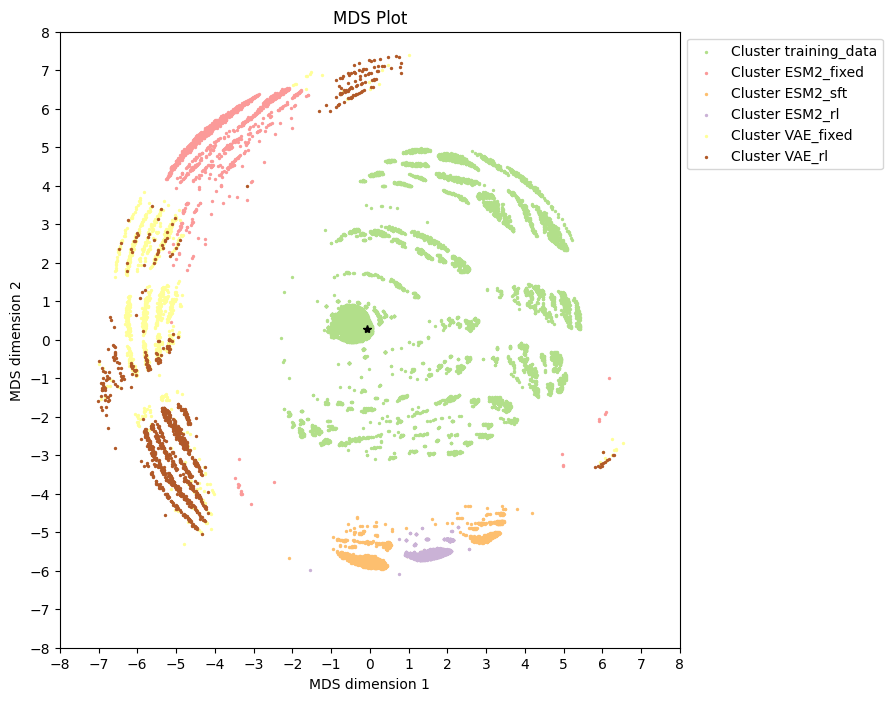

In [21]:
# Assuming df['Cluster'] contains the cluster numbers
clusters = df_combined['source'].unique()
colors = cm.Paired(np.linspace(0, 1, len(clusters)))

# Plot the points color-coded by cluster
plt.figure(figsize=(8, 8))
for cluster, color in zip(clusters, colors):
    if cluster != 'WT':
        idx = df_combined['source'] == cluster
        plt.scatter(X[idx, 0], X[idx, 1], c=[color], label=f'Cluster {cluster}', s=2)

plt.plot(X[0,0],X[0,1],'k*')
# plt.text(X[0,0],X[0,1],'CreiLOV')
    
plt.xlabel("MDS dimension 1")
plt.ylabel("MDS dimension 2")
plt.title("MDS Plot")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim([-8,8])
plt.xlim([-8,8])
plt.xticks(range(-8, 9, 1))
plt.yticks(range(-8, 9, 1))

# Save the figure in the folder with the desired title
plt.savefig(f'./figures/MDS_plot.svg')
plt.savefig(f'./figures/MDS_plot.png')
# plt.show()


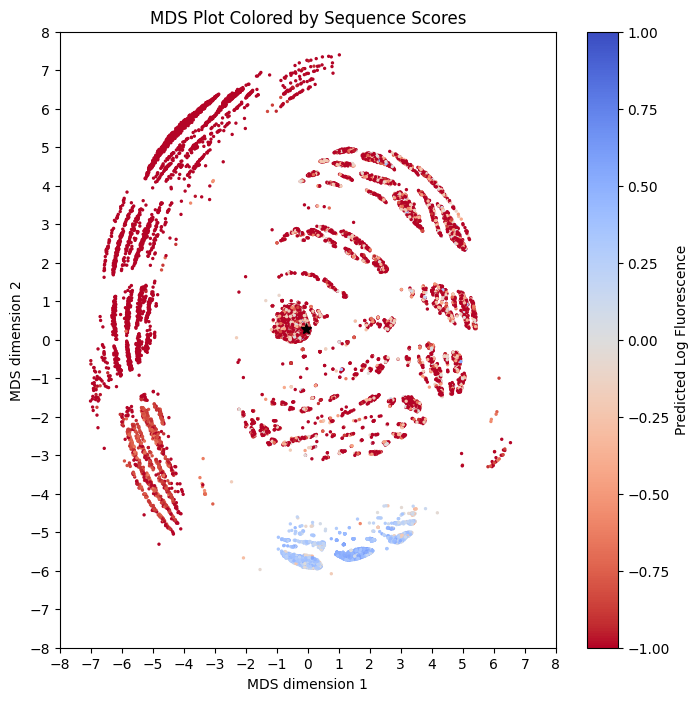

In [22]:
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# Save the figure in the folder with the desired title
scores = df_combined['score']

# Threshold score (center of the diverging colormap)
threshold_score = 4.149827  # CreiLOV predicted log fluorescence

# Center scores relative to threshold
centered_scores = scores - threshold_score

# Find maximum absolute deviation from threshold for symmetric scaling
abs_max = np.max(centered_scores)
abs_min = np.min(centered_scores)

# Rescale centered scores between [-1, 1]
rescaled_scores = centered_scores / abs_max

# Create TwoSlopeNorm centered at 0
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# # Updated smoother diverging colormap
# colors = [
#     "#cb181d",  # Red
#     "#f7f7f7",  # Very Light Grey (close to white) --> at 0
#     "#225ea8"   # Blue
# ]

# cmap = LinearSegmentedColormap.from_list("cmap", colors)
cmap = plt.get_cmap('coolwarm_r')

# Plot the points color-coded by their scores
fig, ax = plt.subplots(figsize=(8, 8))
sc = plt.scatter(X[:, 0], X[:, 1], c=rescaled_scores, cmap=cmap, norm=norm, label='Sequences', s=2)
# sc = plt.scatter(X[:, 0], X[:, 1], c=scores, cmap=cmap, label='Sequences', s=2)

# Highlight a specific point (e.g., CreiLOV)
ax.plot(X[0, 0], X[0, 1], 'k*', markersize=8)

# Labels and title
ax.set_xlabel("MDS dimension 1")
ax.set_ylabel("MDS dimension 2")
ax.set_title("MDS Plot Colored by Sequence Scores")

# Create colorbar
cbar = plt.colorbar(sc, label='Predicted Log Fluorescence', ax=ax)
cbar.ax.axhline(threshold_score, color='black', linewidth=2, linestyle='-')

plt.ylim([-8,8])
plt.xlim([-8,8])
plt.xticks(range(-8, 9, 1))
plt.yticks(range(-8, 9, 1))

# Save the figure in the folder with the desired title
plt.savefig(f'./figures/MDS_plot_with_predicted_scores_heatmap.svg')
plt.savefig(f'./figures/MDS_plot_with_predicted_scores_heatmap.png')
# plt.show()


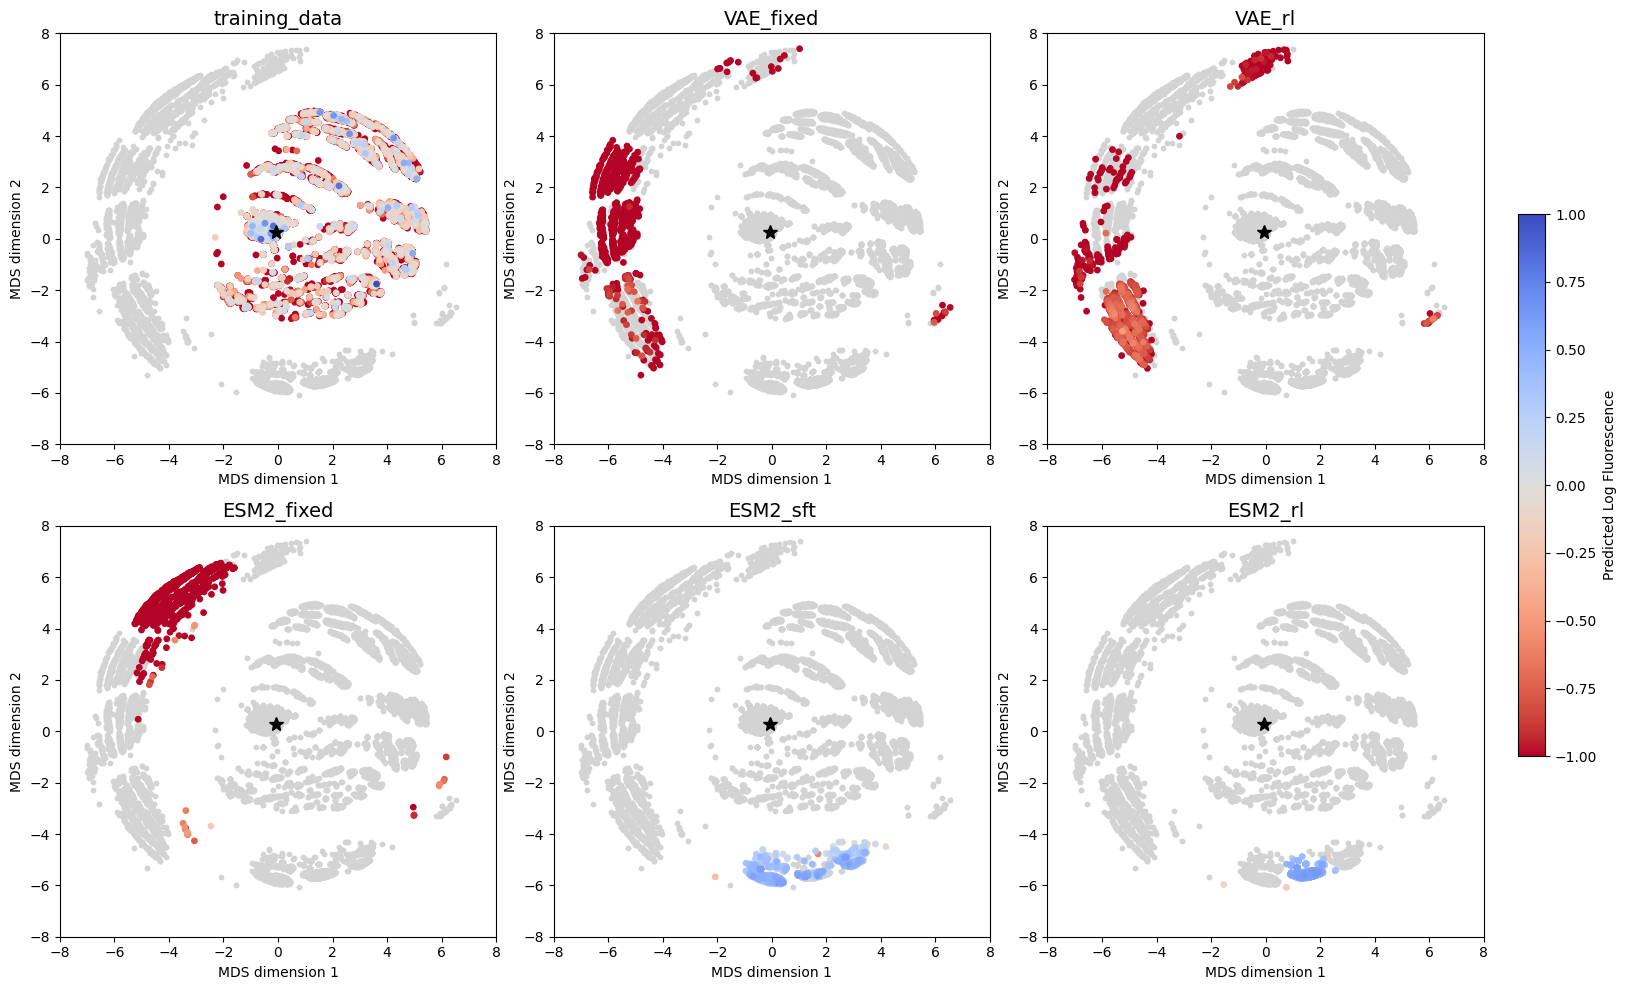

In [23]:
# Assuming df_combined has columns: 'score', 'model' (with labels like 'DMS', 'VAE Pre', 'VAE Align', etc.)
# And X is the MDS coordinates array with shape (n_samples, 2)

models = ['training_data', 'VAE_fixed', 'VAE_rl',
          'ESM2_fixed', 'ESM2_sft', 'ESM2_rl']

# Set up figure
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for idx, model in enumerate(models):
    ax = axs[idx]
    
    # Mask points for the current model
    is_current_model = df_combined['source'] == model
    is_other_model = ~is_current_model  # Inverse mask
    
    # Plot all other points (not current model) in grey
    ax.scatter(X[is_other_model, 0], X[is_other_model, 1], color='lightgrey', s=10)

    # Sort by rescaled_scores so that highest scores are on top
    current_indices = np.where(is_current_model)[0]
    sorted_indices = current_indices[np.argsort(rescaled_scores[current_indices])]
    
    # Overlay colored points for the current model
    sc = ax.scatter(X[sorted_indices, 0], X[sorted_indices, 1], 
                    c=rescaled_scores[sorted_indices], 
                    cmap=cmap, norm=norm, s=15)
    
    # Highlight CreiLOV (assumed to be index 0)
    ax.plot(X[0, 0], X[0, 1], 'k*', markersize=10)
    
    # Labels, title
    ax.set_title(f"{model}", fontsize=14)
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    ax.set_xticks(range(-8, 9, 2))
    ax.set_yticks(range(-8, 9, 2))
    ax.set_xlabel("MDS dimension 1")
    ax.set_ylabel("MDS dimension 2")

# Adjust layout
plt.tight_layout()

# Colorbar
cbar = fig.colorbar(sc, ax=axs, location='right', shrink=0.6, pad=0.02, label='Predicted Log Fluorescence')
cbar.ax.axhline(threshold_score, color='black', linewidth=2, linestyle='-')

# Save
plt.savefig('./figures/MDS_plot_split_by_model.svg')
plt.savefig('./figures/MDS_plot_split_by_model.png')
# plt.show()


In [ ]:
max(scores)

In [ ]:
min(scores)